In [1]:
path = '../../Datasets/wearable-device-dataset-from-induced-stress'
file_name = 'Stress_Level_v1.csv'
full_path = f"{path}/{file_name}"


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(full_path)
df.head()

,Unnamed: 0,Baseline,Stroop,First Rest,TMCT,Second Rest,Real Opinion,Opposite Opinion,Subtract
0,S01,3.0,4.5,4.0,4.0,5.5,6.0,7.0,7.0
1,S02,2.0,4.0,2.0,2.0,2.0,4.0,5.0,4.0
2,S03,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
3,S04,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0
4,S05,1.0,2.0,1.0,4.0,1.0,2.0,2.0,3.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        18 non-null     object 
 1   Baseline          18 non-null     float64
 2   Stroop            18 non-null     float64
 3   First Rest        18 non-null     float64
 4   TMCT              18 non-null     float64
 5   Second Rest       18 non-null     float64
 6   Real Opinion      18 non-null     float64
 7   Opposite Opinion  18 non-null     float64
 8   Subtract          18 non-null     float64
dtypes: float64(8), object(1)
memory usage: 1.4+ KB


## f01 stress HR

In [ ]:
path = '../../Datasets/wearable-device-dataset-from-induced-stress/Wearable_Dataset/STRESS/f01'
file_name = 'HR.csv'
full_path = f"{path}/{file_name}"

In [8]:
df = pd.read_csv(full_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244 entries, 0 to 3243
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   2013-06-12 16:19:08  3244 non-null   float64
dtypes: float64(1)
memory usage: 25.5 KB


In [10]:
df.rename(columns={'2013-06-12 16:19:08': 'HR'}, inplace=True)

In [11]:
df

,HR
0,1.00
1,85.00
2,84.00
3,83.67
4,74.75
...,...
3239,111.47
3240,110.93
3241,110.38
3242,109.57


Text(0, 0.5, 'Heart Rate (bpm)')

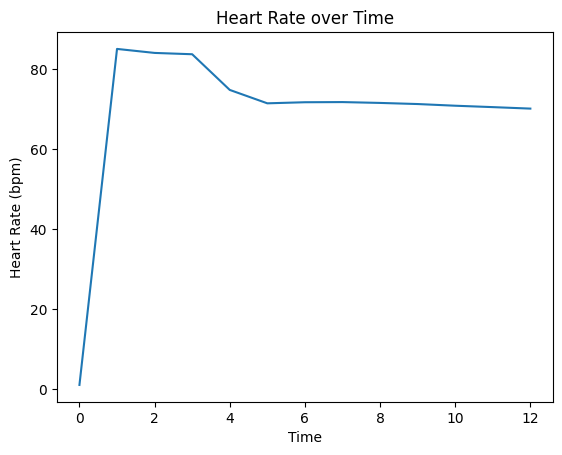

In [13]:
import matplotlib.pyplot as plt

plt.plot(df['HR'][:13])
plt.title('Heart Rate over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')



shape: (3244, 1)
columns: Index(['HR'], dtype='object')
null values:
HR    0
dtype: int64


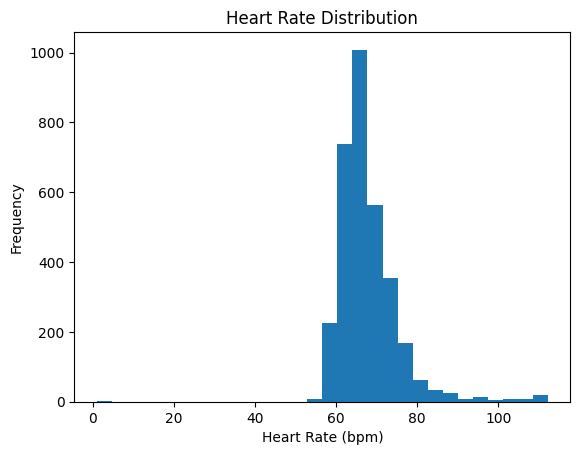

In [14]:
print(f'shape: {df.shape}')
print(f'columns: {df.columns}')
print(f'null values:\n{df.isnull().sum()}')

df['HR'].plot(kind='hist', bins=30, title='Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.show()


In [36]:
fs = 255.0  # Sampling frequency in Hz

In [37]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=1.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [38]:
filtered = bandpass_filter(df['HR'].dropna().values, fs=fs)

In [39]:
type(df['HR'])

pandas.core.series.Series

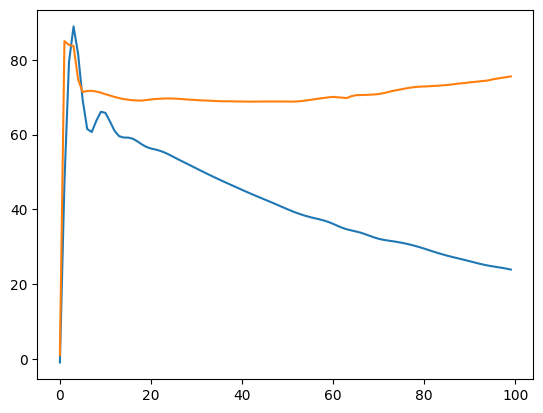

In [40]:
plt.plot(filtered[:100])
plt.plot(df['HR'].values[:100])

In [41]:
from scipy.signal import find_peaks

deriv = np.ediff1d(filtered, to_begin=0)
squared = deriv**2
win_ms = 120
win_samples = max(1, int(win_ms/1000.0 * fs))
integrated = np.convolve(squared, np.ones(win_samples)/win_samples, mode='same')

min_dist = int(round(60.0 / 220.0 * fs))  # حداقل فاصله بین قله‌ها
prom = max((integrated.max()-np.percentile(integrated,75))*0.3, 1e-9)
peaks, _ = find_peaks(integrated, distance=min_dist, prominence=prom)

# اصلاح موقعیت قله به ماکزیمم محلی در سیگنال فیلترشده
search_radius = int(round(0.05 * fs))
r_peaks = []
for p in peaks:
    lo = max(0, p-search_radius); hi = min(len(filtered)-1, p+search_radius)
    r_peaks.append(np.argmax(filtered[lo:hi+1]) + lo)
r_peaks = np.unique(r_peaks).astype(int)

In [42]:
if len(r_peaks) >= 2:
    rr_seconds = np.diff(r_peaks) / fs
    inst_hr = 60.0 / rr_seconds
    print("mean HR:", inst_hr.mean())
else:
    print("Not enough peaks to compute HR")

Not enough peaks to compute HR


In [44]:
import numpy as np
from scipy.signal import welch

def zscore_normalize(w):
    return (w - np.mean(w)) / (np.std(w) + 1e-8)

def time_features(w):
    # استفاده از توابع np.* به‌جای متدهای ndarray
    return np.array([
        np.mean(w),
        np.std(w),
        np.ptp(w),                # peak-to-peak
        np.median(w),
        np.percentile(w, 75) - np.percentile(w, 25)  # IQR
    ])

def freq_band_powers(w, fs, bands=[(0.5,4),(4,8),(8,15),(15,40)]):
    f, Pxx = welch(w, fs=fs, nperseg=min(256, len(w)))
    feats = []
    for (a, b) in bands:
        idx = np.logical_and(f >= a, f <= b)
        if np.any(idx):
            feats.append(np.trapz(Pxx[idx], f[idx]))
        else:
            feats.append(0.0)
    return np.array(feats)

def extract_features_from_window(w, fs):
    wn = zscore_normalize(w)
    t_feats = time_features(wn)
    freq_feats = freq_band_powers(wn, fs)
    return np.concatenate([t_feats, freq_feats])

# سپس ساخت ماتریس ویژگی (با بررسی اینکه windows خالی نباشد)
if wins.size:
    features = np.vstack([extract_features_from_window(w, fs) for w in wins])
else:
    features = np.empty((0, 9))


/var/folders/z1/jg1b__79647749t6sz8jghyw0000gn/T/ipykernel_3540/3547127026.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  feats.append(np.trapz(Pxx[idx], f[idx]))


In [45]:
features

array([[ 0.00000000e+00,  9.99999999e-01,  7.33475207e+00,
        -2.70768900e-01,  5.61300519e-01,  1.32476577e-01,
         8.54262060e-04,  1.32508605e-04,  3.41604912e-05],
       [-3.34373052e-17,  9.99999998e-01,  6.01062978e+00,
        -1.27180676e-01,  1.01113661e+00,  5.77981040e-01,
         8.93545426e-03,  1.26162337e-03,  3.04489308e-04],
       [-2.78644210e-17,  9.99999996e-01,  4.89767315e+00,
         1.19944797e-01,  1.47104252e+00,  6.43094537e-01,
         1.68321853e-02,  1.88727277e-03,  4.35173940e-04],
       [-1.11457684e-17,  9.99999997e-01,  5.41796185e+00,
        -2.78533762e-03,  1.33368631e+00,  5.85630634e-01,
         7.92490453e-03,  8.54196819e-04,  2.76561270e-04]])